## Import essential libraries that will be used in the project


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

### Reading the dataset using pandas


In [35]:
df = pd.read_csv("Fraud.csv")

In [36]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1. Data cleaning including missing values, outliers and multi-collinearity
### Checking for missing values and removing of outliers in this step

In [37]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

From above we can see that there are no missing values in the dataset.
Talking about outliers, there is no point to check for outliers because being it a financial data, the bank balance can be any real value, so we can not check it on any parameter.

### Checking for Multicollinearity:
For this we will use variance inflation factor.
Now, for variance inflation calculation we need to drop non-numeric columns from our dataframe.

In [38]:
copy_df = df.copy(deep=True)
copy_df['type'] = copy_df['type'].map({'PAYMENT':1 ,'TRANSFER':2, 'CASH_OUT':3, 'DEBIT':4, 'CASH_IN':5})
copy_df = copy_df.drop(columns = ['nameOrig','nameDest','isFraud','isFlaggedFraud'])
copy_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,1,9839.64,170136.0,160296.36,0.0,0.0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,2,181.00,181.0,0.00,0.0,0.0
3,1,3,181.00,181.0,0.00,21182.0,0.0
4,1,1,11668.14,41554.0,29885.86,0.0,0.0


In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
variance_data = pd.DataFrame()
variance_data["feature"] = copy_df.columns
variance_data["VIF"] = [variance_inflation_factor(copy_df.values, i )
                        for i in range(len(copy_df.columns))]

print(variance_data)

          feature         VIF
0            step    2.466060
1            type    3.251976
2          amount    4.129854
3   oldbalanceOrg  501.282300
4  newbalanceOrig  508.906801
5  oldbalanceDest   73.377939
6  newbalanceDest   84.656570


From the results we can observe that there are two features namely, oldbalanceOrg and newbalanceOrg, which are high correlated as they have high values of variance inflation

Now there are two types of Fraud, isFraud indicates tha actual fraud whereas isFlaggedfraud tells what the system prevents the transaction due to some threshold

### isFraud:

In [41]:
print("Type of transactions which are fraud: {}".format(list(df.loc[df.isFraud == 1].type.drop_duplicates())))

fraud_transfer = df.loc[(df.isFraud == 1) & (df.type == "TRANSFER")]
fraud_cashout = df.loc[(df.isFraud == 1) & (df.type == "CASH_OUT")]

print("Number of transfers are fraud: {}".format(len(fraud_transfer)))
print("Number of cashouts are fraud: {}".format(len(fraud_cashout)))


Type of transactions which are fraud: ['TRANSFER', 'CASH_OUT']
Number of transfers are fraud: 4097
Number of cashouts are fraud: 4116


### isFlaggedFraud:

In [42]:
flagfraud1 = list(df.loc[(df.isFlaggedFraud == 1)].amount.values)
flagfraud0 = list(df.loc[(df.isFlaggedFraud == 0)].amount.values)

print('minimum amount transfer where isFlaggedFraud is 1 = {}'.format(min(flagfraud1)))
print('maximum amount transfer where isFlaggedFraud is 0 = {}'.format(max(flagfraud0)))
print('Number of isFlaggedFraud == 1 : {}'.format(len(list(df.loc[df.isFlaggedFraud ==1 ].isFlaggedFraud.values))))

minimum amount transfer where isFlaggedFraud is 1 = 353874.22
maximum amount transfer where isFlaggedFraud is 0 = 92445516.64
Number of isFlaggedFraud == 1 : 16


isFlaggedFraud variable is set to 1 when transfer is more than 200,000 in single transaction but we can see that from above analysis. This variable is useless because maximum amount transfer in single transcation is 92445516.64 , There are only 16 values where isFlaggedFraud is set so we will drop this feature

Oldblanceorig and newbalanceorig variable


In [53]:
print('number of recipant who have newbalancedest and oldbalancedest is zero :{}'
      .format(len(df.loc[(df.newbalanceDest == 0) & (df.oldbalanceDest == 0) ].nameDest.values)))

number of recipant who have newbalancedest and oldbalancedest is zero :2317282


In [54]:
zero_balance = list(df.loc[(df.oldbalanceOrg == 0) & (df.newbalanceOrig == 0) & (df.amount != 0)].type.values)

print('Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :{}'.format(len(zero_balance)))

Number of transcation where oldbalanceorig & newbalanceorig is zero but amount of transaction is not zero :2088969


In [55]:
print('number of merchants in originator transaction: {}' .format(df.nameOrig.str.contains('M').any()))
print('number of merchant acoount in destination where type is Transfer : {}' .format(df.loc[df.type =='TRANSFER'].nameDest.str.contains('M').any()))
print('number of merchant acoount in destination where type is cashout : {}' .format(df.loc[df.type =='CASH_OUT'].nameDest.str.contains('M').any()))

number of merchants in originator transaction: False
number of merchant acoount in destination where type is Transfer : False
number of merchant acoount in destination where type is cashout : False


In [56]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
y = x.isFraud
x = x.drop(['isFraud','isFlaggedFraud','nameOrig','nameDest'],axis = 1)
x['type']= x['type'].map({'TRANSFER':1,'CASH_OUT':2})

In [57]:
x.loc[(x.oldbalanceDest == 0) & (x.newbalanceDest == 0) & (x.amount != 0) ,['oldbalanceDest','newbalanceDest'] ] = -1 
x.loc[(x.oldbalanceOrg == 0) & (x.newbalanceOrig == 0) & (x.amount != 0) ,['oldbalanceOrg','newbalanceOrig'] ] = 0 

#imputing missing values

In [58]:
x['errorbalanceorig'] = x.newbalanceOrig + x.amount - x.oldbalanceOrg   # eg origin- oldbal = 10 ,newbal = 8 ,amount = 2 so, error =  8+2-10 = 0 
x['errorbalancedest'] = x.oldbalanceDest + x.amount - x.newbalanceDest   #eg - at dest its opposite , old bal = 8 ,new bal = 10 , amount = 2 :error = 8+2-10 = 0

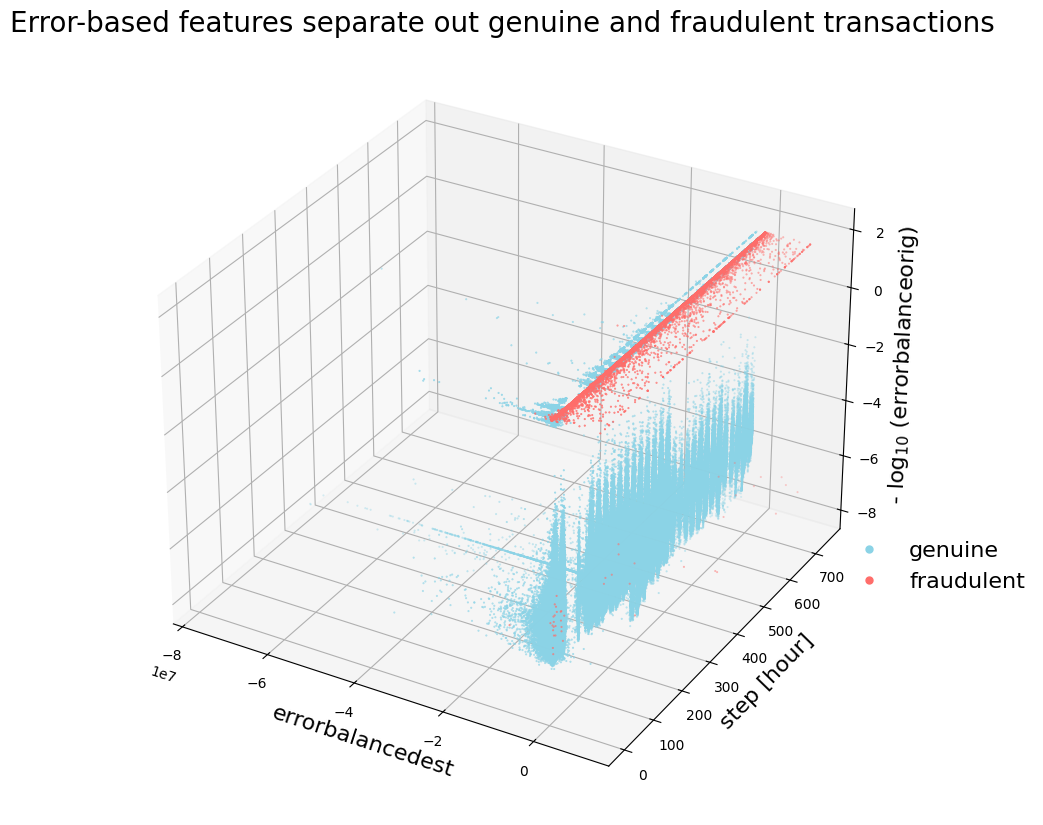

In [63]:
x1 = 'errorbalancedest'                                       
y1 = 'step'
z1= 'errorbalanceorig'
zOffset = 0.02
limit = len(x)

sns.reset_orig() 

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x.loc[y == 0, x1][:limit], x.loc[y == 0, y1][:limit], \
  -np.log10(x.loc[y == 0, z1][:limit] + zOffset), c = '#8BD3E6', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(x.loc[y == 1, x1][:limit], x.loc[y == 1, y1][:limit], \
  -np.log10(x.loc[y == 1, z1][:limit] + zOffset), c = '#FF6D6A', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x1, size = 16); 
ax.set_ylabel(y1 + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z1 + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='#8BD3E6', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='#FF6D6A', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

plt.show()

In [64]:
xfraud = x.loc[y==1]
xnotfraud = x.loc[y == 0]

print(len(xfraud))
print(len(xnotfraud))

8213
2762196


In [65]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=27)

In [66]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())                  #xgb uses the scale_pos_weight to account for highly skewed datset
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights,
                n_jobs = 4)
probabilities = clf.fit(X_train,y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))

AUPRC = 0.3650600457478117
